## Introduction
- Knowing how to distinguesh between the organic and recycle waste is very important as it leads to Waste Reduction, Economic Benefits,Resources Recovery: Recycling allows for the recovery and reuse of valuable materials, and Environmental Protection
- In this notebook we will classify between organig and recycle waste using CNN(Convolutional Nural Network) by PyTorch



In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch
from torchvision import transforms, datasets
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import random

In [2]:
#activate gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
#function to read only the images with size[3.277.277]

def checksize(path):
    img = Image.open(path)
    img = img.resize((227, 227))
    img = transforms.PILToTensor()(img)
    return img.shape == torch.Size([3, 227, 227])

In [4]:
#train and test images with the right size

test = "TEST"
train = "TRAIN"
dataset = "dataset"
train_paths = []
test_paths = []


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if test in os.path.join(dirname, filename) and dataset not in os.path.join(dirname, filename):
               if checksize(os.path.join(dirname, filename)):
                    test_paths.append(os.path.join(dirname, filename))
            
        elif train in os.path.join(dirname, filename) and dataset not in os.path.join(dirname, filename):
            if checksize(os.path.join(dirname, filename)):
                train_paths.append(os.path.join(dirname, filename))


In [5]:
print(len(train_paths), len(test_paths))

22205 2500


In [6]:
#separate the prganic paths to know the number of each class

organic_paths = [path for path in train_paths if 'O' in path]

random.shuffle(train_paths)
random.shuffle(test_paths)

In [7]:
print(f"number of recycle pics: {len(train_paths)-len(organic_paths)}, number of organic pics :{len(organic_paths)}")

number of recycle pics: 9724, number of organic pics :12481


In [8]:
transform = transforms.Compose(
    [
        transforms.PILToTensor(),
    ]
)

In [9]:
class dataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
    
    
    def __getitem__(self, index):
        img = Image.open(self.paths[index])
        img = img.resize((227, 227))
        
        if self.transform:
            img = self.transform(img)
            img = img.type(torch.float32)
       
        
        return img, int('O' in self.paths[index])
                           
    
    def __len__(self):
        return len(self.paths)

In [10]:
train_data_show = dataset(train_paths)
train_data = dataset(train_paths, transform)
test_data = dataset(test_paths, transform)

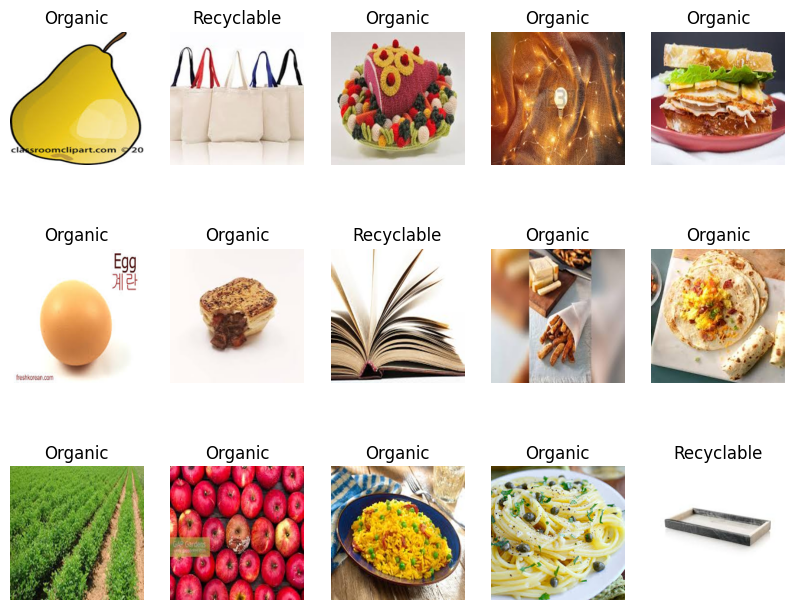

In [11]:
#show some images from training set
plt.figure(figsize=(10, 8))
for index in range(15):
    image, label = train_data_show[index]
    ax = plt.subplot(3, 5, index+1)
    if label == 1:
        plt.title("Organic")
    else:
        plt.title("Recyclable")
    plt.axis("off")
    plt.imshow(image)

In [12]:
#dataloaders

train_loader = DataLoader(train_data, batch_size=32, shuffle=True,)
test_loader = DataLoader(test_data, batch_size = 32, shuffle=False)

In [13]:
#our CNN -> similar to Alexnet

class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        
        self.blocks = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size= 3, stride=2),
        nn.Conv2d(96, 256, kernel_size=5, padding='same'),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(3, 2),
        nn.Conv2d(256, 384, kernel_size=3, padding='same'),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 384, kernel_size=3, padding='same'),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 256, kernel_size=3, padding='same'),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(3, 2)
        )
        
        self.linears = nn.Sequential(
            nn.Linear(9216, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2)
        )
        
    def forward(self, x):
        out = self.blocks(x)
        out = nn.Flatten()(out)
        out = self.linears(out)
        
        return out
          

In [14]:
model = cnn().to(device)

num_epochs = 20
criterion = nn.CrossEntropyLoss()
lr = 0.005
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
tol = 0
train_losses = []
test_losses = []
best_score = float('inf')

In [15]:
def train_epoch():
    epoch_loss =0
    for i, (images, labels) in enumerate(train_loader):
    
        images = images.to(device)
        labels = labels.to(device)
        #forward pass
        out = model(images)
        loss = criterion(out, labels)
        epoch_loss += loss
        
        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if(i%200 ==0):
            print(f"   step[{i+1} / {len(train_loader)}]")
        
    return epoch_loss / len(train_loader)

In [16]:
def test_loss():
    epoch_loss =0;
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            out = model(images)
            loss = criterion(out, labels)
            epoch_loss += loss
            
    return epoch_loss / len(test_loader)

In [17]:
    for epoch in range(num_epochs):
        print(f"epoch {epoch+1}:")

        model.train(True)
        avg_train_epoch_loss = train_epoch()

        model.eval()
        avg_test_epoch_loss = test_loss()

        if(avg_test_epoch_loss < best_score):
            best_score = avg_test_epoch_loss
            torch.save(model.state_dict(), f"model_{epoch+1}")
        else:
            tol+=1
            if(tol == 6):
                break

        train_losses.append(avg_train_epoch_loss)
        test_losses.append(avg_test_epoch_loss)

        print(f"epoch: {epoch+1} --- avg_train_loss = {avg_train_epoch_loss} --- avg_test_loss = {avg_test_epoch_loss}") 
        print("#"*100)

epoch 1:
   step[1 / 694]
   step[201 / 694]
   step[401 / 694]
   step[601 / 694]
epoch: 1 --- avg_train_loss = 0.4786956310272217 --- avg_test_loss = 0.3908148407936096
####################################################################################################
epoch 2:
   step[1 / 694]
   step[201 / 694]
   step[401 / 694]
   step[601 / 694]
epoch: 2 --- avg_train_loss = 0.4183295965194702 --- avg_test_loss = 0.3261730968952179
####################################################################################################
epoch 3:
   step[1 / 694]
   step[201 / 694]
   step[401 / 694]
   step[601 / 694]
epoch: 3 --- avg_train_loss = 0.39377525448799133 --- avg_test_loss = 0.35368549823760986
####################################################################################################
epoch 4:
   step[1 / 694]
   step[201 / 694]
   step[401 / 694]
   step[601 / 694]
epoch: 4 --- avg_train_loss = 0.3720252215862274 --- avg_test_loss = 0.37467968463897705
##########

In [18]:
train_losses = [ x.item() for x in train_losses]
test_losses = [ x.item() for x in test_losses]

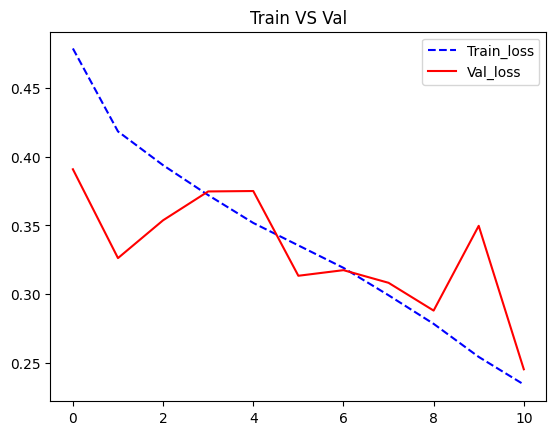

In [19]:
plt.plot(train_losses, "b--", label = "Train_loss")
plt.plot(test_losses, "r-", label = "Val_loss")
plt.title("Train VS Val")
plt.legend()
plt.show()